# Mobile Robotics Project Report

## Table of Content:
* [1. Introduction](#Introduction)
* [2. General program flow](#General_program_flow)
* [3. Computer Vision](#Computer_vision )
    * [3.1 Robot detection and localisation](#31-robot-detection-and-localisation)
    * [3.2 Obstacle Detection](#32-obstacle-detection)
    * [3.3 Path Planning](#33-path-planning)
    * [3.4 Goal Identification](#34-goal-identification)
* [4. Filtering](#Filtering)
    * [4.1 The state space model](#41-the-state-space-model)
    * [4.2 Filter choice and parameters](#42-filter-choice-and-parameters)
    * [4.3 Running the filter](#43-running-the-filter)
* [5. General Motion](#General_motion)
* [6. Local avoidance](#Local_avoidance)
    * [6.1 Requirements on the obstacles for local avoidance](#61-requirements-on-the-obstacles-for-local-avoidance)
    * [6.2 Local avoidance implementation](#62-local-avoidance-implementation)
* [7. Kidnapping](#Kidnapping)
* [8. Conclusion](#Conclusion)
  


## Project: Autonomous Navigation System for a Mobile Robot

### Participants:
- **Alexis Limozin  (330717)**
- **Parth Aggarwal  (376263)**
- **Serge El Asmar   (326623)**
- **Quentin Angéloz (325935)**

---

# 1. Introduction <a class="anchor" id="Introduction"></a>
The aim of our project is to manage the thymio's path to a target in an environment containing obstacles.
Our project uses a camera to create a map of the environment, taking obstacles into account. The thymio plans its path based on this map, and travels to where the obstacle is. If the environment changes and the robot detects an unexpected obstacle, the camera generates a new map that takes the new obstacle into account, and the thymio corrects its route.
## Assumptions and environment description
- The environment is a plane.
- The ground is only one color, not green, not black and not red.
- Obstacles color is black
- The goal color is green
- Operate the camera, obstacles and robot in a controlled environment
- The Thymio is identified by two unique pieces of red tape

## Environment Visual

<img src="images/setup.jpg" width="550" height="700">



## 2. General program flow <a class="anchor" id="General_program_flow"></a>
### The overall program sequence is as follows:

The robot has 4 different states, which are the body of the program.

In each of these states, an image is periodically acquired.

When the program starts, the robot is in state 0. 
- State 0
    - The program searches for the robot until a path from the robot's position to the target can be calculated and stored in memory. Once this has been done, the robot switches to state 1.
- State 1
    - The robot follows the previously calculated path. It regularly corrects its trajectory using the Kalman filter.
    - If the robot is kidnapped, it enters state 3.
    - If the robot detects an unexpected obstacle, it enters state 2.
    - If the robot has reached its goal, it stops.
- State 2:
    - the robot moves backwards until it can no longer see an obstacle, then returns to state 0.
- State 3:
    - the robot stops moving, and waits to be put back on the ground. When this is done, it returns to state 0.

A simple diagram of the finite state machine is given below.

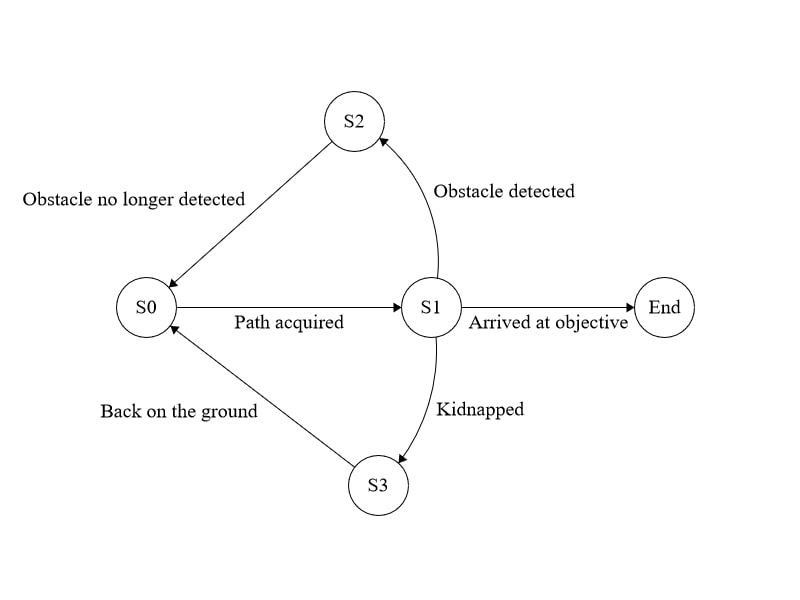

In [1]:
from IPython.display import HTML, Image
Image(filename='images/FSM.jpg', width=400, height=500) 

### Use of asynchronous programming
Asynchronous programming was used to send command signals to the motor, to read values from the robot's proximity sensors and to read values from the motor speeds.

The following cell contains a video illustrating a simple case of the general program flow. In the video, the robot is never kidnapped, and no unplanned obstacle is being placed on its path, therefore, local navigation is never used here.

In [10]:
HTML(f"""
<video width="640" height="480" controls>
  <source src="videos/normal_behavior.mp4" type="video/mp4">
  Error, can't play video
</video>
""")

# 3. Computer vision <a class="anchor" id="Computer_vision"></a>

In [3]:
from vision.ComputerVision import Vision

To install the libraries used in vision:

In [6]:
!pip install opencv-python
!pip install numpy
!pip install pyvisgraph
!pip install shapely

The vision aspect of our project is designed to navigate the robot through an environment with obstacles utilising a stationary camera. Our approach follows the following steps:

1. Detecting and locating the robot and its orientation 
2. Identifying obstacles and their boundaries 
3. Determining a goal position 
4. Computing the shortest path for the robot to reach the goal while avoiding obstacles. 

### Libraries used to aid Vision 
- `OpenCV`: Used for image detection, contour detection, geometric transformations, utilised to process captured frames and purpose the visual input to achieve the goal 
- `NumPy`: Utilised for all numerical operations
- `Pyvisgraph`: Utilised for computing optimal robot paths based on all calculations 
- `Shapely`: Utilised for manipulating planar geometric objects (to create union between obstacles that are close together)

Below is a code snippet showing how the vision code is organized using classes. In order to make the interfacing as seamless as possible, all the vision code is contained within the vision/ComputerVision.py file. There is one main class where each object attributes can be accessed. More detail in its usage in vision/README.md

In [ ]:
class Robot:
    def __init__(self, x, y, angle):
        self.x = x
        self.y = y
        self.angle = angle

class Goal:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Main class used to interface with vision
class Vision:
    # Initialise cam, frame, copy of frame, robot, scale, graph,
    # obstacle vertices, shortest_path
    def __init__(self):
        self.cam = cv2.VideoCapture(0)
        valid, self.frame = self.cam.read()
        if not valid:
            print("Error reading frame.")
        self.copy = self.frame.copy()
        self.found_robot, self.robot, self.scale = self.find_robot()
        self.found_graph, self.vertices, self.graph = self.find_graph()
        self.found_goal, self.goal = self.find_goal()
        self.shortest_path = []
    
    # ...

The simplest usage of the vision code without any robot control can be done with the following code snippet, in vision/test_main.py

In [ ]:
from vision.ComputerVision import Vision
import time
import cv2

vis = Vision()
# Initialize a variable to store the last time an image was acquired
last_image_time = time.time()

while True:
    # Check if it's been at least 0.05 second since the last image acquisition
    if time.time() - last_image_time < 0.05:
        continue
    vis.show()
    path = vis.shortest_path
    vis.update(path)

    # Update the last image acquisition time
    last_image_time = time.time()

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

del vis

### 3.1. Robot Detection and Localisation <a name="31-robot-detection-and-localisation"></a>

This is conducted throught the `find_robot()` function which operates solely on the defined vision class (as such this is the sole input). It accomplishes this through advanced image processing techniques, focusing on color filtering and contour detection, followed by a detailed analysis of the detected shapes.

Firstly, through *colour filtering* the image is converted from its original BGR format to RGB. We then apply a colour filter to isolate the colour red, which is present on the thymio robot (as per our assumptions). This is achieved through defining a specific range in the RGB colour space that corresponds to the red colour, resulting in a binary mask where the red areas are highlighted. 

Then we undergo *contour detection* by using `cv2.findContours()` to detect the exact shape and structure of the labelling on the thymio. These contours, representing the boundaries of the red shapes are critical for the accurate determination of the robot's position. A specific range of contour areas are checked, to denoise the result and only get the two markers contours and positions. The contour area feature is also used to differentiate between the nose marker and the tail marker on the robot.

This structure allows us to *calculate the centroids* by utilising the moments of the two contours. `cv2.moments()` allows for extraction of specific spatial moments required to compute the coordinates of the centroid which are calculated using the following formulae:

$$C_x = \frac{M_{10}}{M_{00}},\; C_y = \frac{M_{01}}{M_{00}}$$ 

The calculation of this centroid helps provide 5 critical pieces of information:
1. **Central reference point**: Concise and accurate position of robot in environment, calculated from the average of the two markers position.
2. **Orientation of robot**: The direction in which the robot is facing is inferred from the arctangent of the two centroids locations. 
3. **Scale Calibration**: By knowing the physical distance between the two marker centroids on the robot and comparing it with the pixel distance between their centroids in the image, you can establish a scale factor, providing the scale for all future calculations.
4. **Movement Analysis**: The centroid can be tracked in sequential frames, thus, changes in the centroid's location over time provide information about the speed and direction of the robot's movement. 
5. **Path Planning Input**: The positional data derived from the centroids assist significantly in the path planning process, to be elaborated later in the report. 

Below is an image of the robot with its two markers and orientation detected:

<img src="images/Robot.PNG">

The code in the cell below is the part of the vision code implementing the robot detection.

In [ ]:
import numpy as np

# Function to find robot location and frame scale
def find_robot(self):
    # Convert the image from BGR to RGB (OpenCV loads images in BGR by default)
    rgb_image = cv2.cvtColor(self.frame, cv2.COLOR_BGR2RGB)

    # Define the lower and upper bounds for the red color in RGB
    lower_red = np.array([150, 20, 60])
    upper_red = np.array([255, 100, 140])

    # Create a binary mask using inRange function
    red_mask = cv2.inRange(rgb_image, lower_red, upper_red)

    # Apply the binary mask to the original image
    result = cv2.bitwise_and(self.frame, self.frame, mask=red_mask)

    # Convert the result to grayscale
    gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    gray_result = cv2.bilateralFilter(gray_result,5,15,15)
    contours, _ = cv2.findContours(gray_result, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 200
    max_area = 10000
    centroid = [0,0]

    total = 0
    nose_size = 0
    # Draw the contours
    for i, contour_i in enumerate(contours):
        contour_area_i = cv2.contourArea(contour_i)
        if min_area < contour_area_i < max_area:
            total +=1
            nose_size = max(nose_size, contour_area_i)

    if total == 2:  #Here we have found the robot
        for _, contour_i in enumerate(contours):
            contour_area_i = cv2.contourArea(contour_i)

            if min_area < contour_area_i < max_area:
                # Selecting the nose side of the robot with i = 0
                if contour_area_i == nose_size:
                    i = 0
                else:
                    i = 1
                color = (0, 0, 255)
                cv2.drawContours(self.copy, [contour_i], 0, color, 2)
                M = cv2.moments(contour_i)
                centroid[i] = np.array([int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])])
        cv2.line(self.copy, centroid[0], centroid[1], (0,0,255),2)

        # The real distance between the two markers on the robot is around 8.5 cm. so we set a scale
        # to know how distant the objects are from the camera.
        scale = np.linalg.norm(centroid[0] - centroid[1])/0.085

        return True, Robot((centroid[0][0] + centroid[1][0])/2.0, (centroid[0][1] + centroid[1][1])/2.0,
                    np.arctan2(centroid[0][1]-centroid[1][1],centroid[0][0]-centroid[1][0])), scale
    else:
        return False, Robot(0,0,0), 0 # Default value if robot not found

### 3.2. Obstacle Detection <a name="32-obstacle-detection"></a>
This is achieved through the `find_graph()` function which again takes in the vision class as its sole input. Obstacle detection is achieved through Greyscale conversion, thresholding, contour approximation which blends together to contribute to larger objective of creating a map for the robot to follow. 

The first step is *Greyscale Conversion* which significantly simplifies the process of identifying obstacles through `cv2.cvtColor()`. In greyscale, the intensity of each pixel represents different shades of grey, disregarding colour which is not needed to identify black (all obstacles are black as stated in assumptions). Once the image is rendered, *Thresholding* takes place which outputs an image where the black obstacles are distinctly visible against the background. 

In a similar process to above, the contours are detected but for obstacles, they are further simplifed in the process of *Contour Approximation* utilising `cv2.approxPolyDP()` to create the shape of the obstacles. This returns the object (obstacle) defined as a set of corners. This is done in order to balance between retaining the essential shape while reducing computational complexity. This serves to keep the algorithm efficient while maintaining accuracy. 

Finally, the boundaries of the actual obstacles and the robot have been defined. But in order to ensure that the path planning function is able to create a safe path through the obstacles, we conduct a *Vector Calculation* for Obstacles. 
This is done in `find_farthest_vector()` which takes in the set of corners for each of the obstacles, with the end goal being to create a safety net around obstacles to avoid collision. For each corner, this function calculates the sum of two vectors made from a two vectors [previous_corner, corner] and [next_corner, coner] (in green and blue in the image below) and normalizes it. We then get the vector pointing outward relative to an obstacle for each corner of an obstacle (final vector in red in the image below).

Then we can set the corners of each obstacles at a certain distance (determined using the scale factor obtained from the `find_robot()` function) along this vector from the obstacle. This helps create a buffer around the obstacles hence preventing the robot's path from getting too close to an obstacle. This also allows for the accomodation of any errors in measurement or movement.

The image below illustrates the result of this part of the code.

<img src="images/Obstacle_detection.PNG" width=700 height=500>

The code in the cell below is the part of the vision code implementing the obstacle detection.

In [ ]:
# Function to find the vector pointing outwards from a corner
def find_vector_farthest(corner, corners):    
    corners = corners.reshape(-1, 2)

    # Find the index of the corner in the list of corners
    corner_index = np.where((corners == corner).all(axis=1))[0][0]

    # Get the total number of corners
    num_corners = len(corners)

    # Get the indices of the previous and next corners in a circular manner
    prev_corner_index = (corner_index - 1) % num_corners
    next_corner_index = (corner_index + 1) % num_corners

    # Get the previous and next corners
    prev_corner = corners[prev_corner_index]
    current_corner = corners[corner_index]
    next_corner = corners[next_corner_index]
    
    # Calculate vectors from the current corner to the previous and next corners
    vector_prev = normal(np.float32(current_corner - prev_corner))
    vector_next = normal(np.float32(current_corner - next_corner))
    vector_farthest = normal(vector_prev + vector_next)

    return vector_farthest

# Function to return the normal of a vector
def normal(v):
    length = np.sqrt(v[0]**2+v[1]**2)
    v[0] = v[0]/float(length)
    v[1] = v[1]/float(length)
    return v

# Function to find the obstacles and make the visibility graph
def find_graph(self):
    #Convert the frame to grayscale
    gray = cv2.cvtColor(self.frame, cv2.COLOR_BGR2GRAY)
    # Apply some preprocessing
    gray = cv2.bilateralFilter(gray,5,15,15)
    # Apply a binary threshold to identify black pixels
    _, binary = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    # Find contours in the binary image along with hierarchy
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Set contour area thresholds
    min_area = 1000
    max_area = 100000

    # Approximation accuracy
    epsilon = 0.025

    # Store points and obstacles
    points = []
    obstacles = []
    found_obstacles = False

    for contour_i in contours:
        contour_area_i = cv2.contourArea(contour_i)

        if min_area < contour_area_i < max_area:
            found_obstacles = True
            # Draw the contours
            color = (0, 255, 150)
            cv2.drawContours(self.copy, [contour_i], 0, color, 2)

            # Find the corners of the contour
            corners = cv2.approxPolyDP(contour_i, epsilon * cv2.arcLength(contour_i, True), True)
            obstacle_i = []

            # Draw circles at each corner
            for corner in corners:
                # Find the vector pointing outward from the corner
                vector_farthest = find_vector_farthest(corner[0], corners)
                # Place a point at a distance of 13 cm from the corner using the 
                # SCALE we have found earlier from the robot
                new_point = corner[0] + self.scale * 0.13 * vector_farthest
                points.append(new_point)
                obstacle_i.append((int(new_point[0]),int(new_point[1])))
            if len(obstacle_i) >= 3:
                obstacles.append(Polygon(obstacle_i))


    # Build the visibility graph for the given points and obstacles
    g = vg.VisGraph()

    # ...

### 3.3. Path Planning <a name="33-path-planning"></a>
The first step is to construct a visibility graph utilising `pyvisgraph` and general graph theory to visualise the corners of obstacles, robot's current position, and the goal. This is built in `find_graph` which goes through *Greyscale and Thresholding*, *Contour Detection and Polygon Approximation* and then *Vector Calculation for Safety Margins*. 

Once this processing is done, the space between obstacles is checked to ensure enough space for a thymio to travel through. For that, an algorithm checks if each polygon formed from the nodes around an obstacle intersect with other polygons. If two polygons are intersecting, they are combined into a bigger polygon, which the thymio will go around. This is done with the help of functions from the `shapely` library.

Finally, the visibility graph is built with the help of the `pyvisgraph` library, by feeding it a list of non-intersecting polygons coordinates. This will determine which all the neighbours of each node and store them in an object.

The `find_shortest_path()` function in the Vision class plays a pivotal role in the robot's navigation system. Taking in the above map where there are the integrated outputs from the robot detection, obstacle detection, and goal identification processes to compute the optimal path for the robot to reach its goal using Djikstra's algorithm. 

Continuing on from the 3.2. `find_graph()` function, the next part implements the polygons intersection detection and visibility graph building.

In [ ]:
    # ...

    # Build the visibility graph for the given points and obstacles
        g = vg.VisGraph()

    # Error catching because geometry of obstacles might be bad if a non-obstacle
    # is detected
    try:
        if found_obstacles:
            # Combining obstacles if they intersect
            exclude_list = []
            for i in range(len(obstacles)):
                for j in range(i+1, len(obstacles)):
                    if obstacles[i].intersects(obstacles[j]):
                        exclude_list.append(i)
                        obstacles[j] = unary_union([obstacles[i],obstacles[j]])

            # Making a new list of non-intersecting polygons to use for graph making
            new_obstacles = []
            for i, obstacle in enumerate(obstacles):
                if i not in exclude_list:
                    coords = list(obstacle.exterior.coords)
                    new_obstacles.append([vg.Point(coord[0], coord[1]) for coord in coords])

            # Draw the points
            for point in points:
                cv2.circle(self.copy, point.astype(int), 5, (255, 0, 0), -1)
            g.build(new_obstacles)
    except:
        return False, points, g
    return found_obstacles, points, g

### 3.4. Goal Identification <a name="34-goal-identification"></a>
The function `find_goal()` is utilised to identify the green marker which is placed at the end objective (as per assumptions). This function operates in the vision class and returns the centroid position of the goal. As part of the Vision class, this method ensures that the goal's location is consistently updated and integrated with the robot's navigation system.

Similar to the Robot localisation, this function operates by first applying colour filtering to isolate green (as per assumptions about the goal colour). This mask is then applied to the image and contours are attached to accurately grasp the goal. Following the same process as the Robot Localisation above, centroids are calculated and the end goal of the robot is saved into the vision class, making it accessible for future calculations.

Below is an image of the detected goal seen by the vision algorithm

<img src="images/Goal.PNG">

And below is the code implementing this:

In [ ]:
# Function to find the goal location
def find_goal(self):
    # Convert the image from BGR to RGB
    rgb_image = cv2.cvtColor(self.frame, cv2.COLOR_BGR2RGB)

    # Define the lower and upper bounds for the goal color in RGB (assuming green)
    lower_green = np.array([75, 120, 105])
    upper_green = np.array([95, 140, 125])

    # Create a binary mask
    green_mask = cv2.inRange(rgb_image, lower_green, upper_green)
    # Apply some preprocessing
    green_mask = cv2.bilateralFilter(green_mask,5,15,15)
    # Find contours
    contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if cv2.contourArea(contour) > 100:  # threshold for goal size
            # Draw the contours
            color = (0, 255, 0)
            cv2.drawContours(self.copy, [contour], 0, color, 2)
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                return True, Goal(cx, cy)

    return False, Goal(0, 0)  # Default value if goal not found

# 4. Filtering <a class="anchor" id="Filtering"></a> 

The implementation of a Kalman filter is necessary to obtain smooth performance. It allows our robot to obtain a more precise estimate of its position. Furthermore, if at some point the vision loses the robot (or the robot is hidden), the position estimate will still get updated thanks to the motion model. However, our uncertainty on position will increase until a new camera measurement is given.

### 4.1 The state space model <a name="41-the-state-space-model"></a>
The model is obtained through wheel odometry and the measurements through the output of the computer vision algorithm.
A state space representation of our model can be given as follows:
\begin{equation}
        x_t = \begin{bmatrix}
        1&0&0\\
        0&1&0\\
        0&0&1\\
        \end{bmatrix} x_{t-1} + \begin{bmatrix}
                                \frac{R}{2}cos(x_{3,t-1})\Delta t & \frac{R}{2}cos(x_{3,t-1})\Delta t\\
                                \frac{R}{2}sin(x_{3,t-1})\Delta t & \frac{R}{2}sin(x_{3,t-1})\Delta t\\
                                -\frac{R}{d}\Delta t & \frac{R}{d}\Delta t\\
                                \end{bmatrix} u
\end{equation}

\begin{equation}
        y_t = \begin{bmatrix}
        1&0&0\\
        0&1&0\\
        0&0&1\\
        \end{bmatrix} x_t
\end{equation}

with R the radius of the wheels, d the wheelbase of the thymio and:

\begin{equation}
        x_t = \begin{bmatrix}
                x_{1,t}\\
                x_{2,t}\\
                x_{3,t}\\
                \end{bmatrix} = \begin{bmatrix}
                                x_t\\
                                y_t\\
                                \theta_t\\
                                \end{bmatrix} \text{and } u = \begin{bmatrix}
                                                                \omega_r\\
                                                                \omega_l\\
                                                                \end{bmatrix}
        \end{equation}

### 4.2 Filter choice and parameters <a name="42-filter-choice-and-parameters"></a>
We can see in the model above that our model has no non-linearities ($x_{3,t-1}$ is already known at time $t$ so $cos(x_{3,t-1})$ and $sin(x_{3,t-1})$ are scalars). We can therefore use a linear Kalman filter.

We decided to use the KalmanFilter class from the filterpy library.

In [ ]:
!pip install filterpy

Find below snippets from the filtering.py file:

In [ ]:
from filterpy.kalman import KalmanFilter
import numpy as np
import cv2
import math

We start by defining the filter's parameters as follows:

In [ ]:
## General parameters
dimension_x = 3 # State dimension
dimension_z = 3 # Measurement dimension

motor_scale = 43.52 # [Motor_space/(rad/s)] Scale of motor speeds in motor space to rad/s
R = 0.021 # [m] The radius of the Thymio's wheels
d = 0.095 # [m] The wheelbase of the Thymio
dt = 0.137 # [s] Time delta between steps

# Creating the filter
f = KalmanFilter(dim_x=dimension_x, dim_z=dimension_z) # state and measurement variables are x, y and theta

## Filter parameters
# State transition matrix
f.F = np.eye(3)        
# Measurement function
f.H = np.eye(3)
# Initial covariance matrix
f.P = np.eye(3) * 100
# Measurement noise
camera_variances = [2.13554018e-01, 2.93571267e-01, 6.02748876e-05]
f.R = np.diag(camera_variances)
# Process noise
process_variances = [3.8751605996417765e-01, 3.8751605996417765e-01, 2.9656863710880975e-03]
f.Q = np.diag(process_variances)

The parameters above were defined as follows:
- General parameters:
    - R: Radius of the wheels, measured directly on the thymio.

    - d: Wheelbase, measured directly on the thymio.

    - dt: Average time between two calls, measured by running the code and keeping track of the time 
    between two calls of the filter.
    
    - Motor scale: Scale in $[\text{motor space}\cdot (\frac{rad}{s})^{-1}]$ to convert motor velocities to $rad\cdot s^{-1}$
- Filter parameters:
    - f.F: State transition matrix, identity matrix as seen in the model in 4.1.

    - f.H: Measurement function, identity matrix as seen in the model in 4.1.

    - f.P: Initial value of the position estimate covariance matrix. It is set to an arbitrarly large initial value so it converges once the first measurement is given.

    - f.R: Covariance matrix of the measurement (output of vision algorithm). This was initially estimated by keeping the robot static and running the vision algorithm. We kept track of the returned position in a table and calculated the variance. The value obtained was later hand-tuned to obtain better results.
    
    - f.Q: Covariance matrix of the process (wheel odometry). This was initially estimated by having the robot advance with a constant speed command. We recorded the angular velocity of the wheels. We then translated each recorded angular velocity to a linear velocity in $x$, then multiplied by dt to get the change in $x$ over a constant dt. The variance of this change gives us the variance along $x$. We then assumed $\text{Var}(x)=\text{Var}(y)$. Finally, the variance along $\theta$ was calculated similarly, by having the robot rotate at a constant rate. The obtained values were then hand-tuned to obtain better results.

### 4.3 Running the filter <a name="43-running-the-filter"></a>
We can now present the `run_filter()` function. This function is called every time we want to run one iteration of the filter and obtain a position estimate. 

In [ ]:
def run_filter(speed_right, speed_left, prev_angle, vis):
    global f

    camera_scale = vis.scale # [camera_coordinates/m]
    # Converting the motors to rad/s
    speed_right = speed_right / motor_scale
    speed_left = speed_left / motor_scale
    
    # Defining control input and control transition matrix
    u = np.array([[speed_right],
                  [speed_left]])
    B = np.array([[np.cos(prev_angle)*(dt/2), np.cos(prev_angle)*(dt/2)],
                    [np.sin(prev_angle)*(dt/2), np.sin(prev_angle)*(dt/2)],
                    [(-dt/d), (dt/d)]]) * R
    
    # Getting camera measurements and conveting to [m]
    measurement = np.array([vis.robot.x/camera_scale, vis.robot.y/camera_scale, vis.robot.angle])
    
    # Predict step of kalman filter with control input
    f.predict(u = u, B = B)
    # Only update if we have new camera measurements
    if vis.found_robot:
        f.update(measurement)

    # Defining the estimate in camera coordinates
    estimate = np.array([f.x[0,0] * camera_scale, f.x[1,0] * camera_scale, f.x[2,0]])

    # Plotting an ellipse to show evolution of uncertainty along x and y
    cv2.ellipse(vis.copy, (int(estimate[0]), int(estimate[1])), (int(200 * f.P[0,0]), int(200 * f.P[1,1])), math.degrees(f.x[2,0]),0,360,(255,0,0),3)
    # Plotting a line to show the angle estimate
    cv2.line(vis.copy, (int(estimate[0]), int(estimate[1])), (int(estimate[0] + 100*np.cos(estimate[2])), int(estimate[1] + 100*np.sin(estimate[2]))), (255,0,0), 3)
    
    return estimate # Return the kalman filtered state

The function performs calulcations in SI units so the first step is to convert `speed_right` and `speed_left` (the motor angular velocities) from motor space to SI using `motor_scale`. We can then initialize the control input `u` and control transition matrix `B` based on the motor angular velocities and the angle `prev_angle` obtained from the previous iteration of the filter. Afterwards we divide the $x$ and $y$ measurements by `camera_scale` to convert them from the camera's units to meters. The $\theta$ measurement doesn't need to be scaled as the vision algorithm returns it in radians.

We are now ready to run the predict step of the kalman filter using the `predict()` function from the `KalmanFilter` class. This function has optional arguments `u` and `B`, depending on whether the used model has a control input. Once the filter is done predicting, we use `vis.found_robot` to check if the vision algorithm has found the robot. If it has not, then we do not run the update step and will return the a priori position estimates, we also expect the covariance matrix `f.P` to grow. However, if the vision algorithm has seen the robot then we update the estimate with the measurements from the camera and return the a posteriori estimates.

Before returning the position estimates we reconvert them to the camera coordinate space using `camera_scale` (once again, we do not need to convert the $\theta$ estimate). The rest of the function plots a line representing the estimate of $\theta$ and an ellipse representing the variance along $x$ and $y$. Note that the variances were scaled by a value of 200 to obtain a visible ellipse. The goal of this ellipse is simply to visualize the evolution in the variances as the filter runs.

In the video below we hide the robot with a piece of paper. As expected, the filter's variance increases until a new measurement is acquired. We can see the filter is able to maintain a viable estimated position to keep the robot on its path. (reminder: the variance ellipse's size was scaled by 200).

In [7]:
HTML(f"""
<video width="640" height="480" controls>
  <source src="videos/filter.mp4" type="video/mp4">
  Error, can't play video
</video>
""")

# 5. General motion

When the program has been able to calculate the path the robot must take, it has a list of coordinates in memory, which are the positions the robot must pass through to reach the goal.

Here we describe how the robot follows the trajectory from one point to another, without kidnapping and without unexpected obstacles in its path.

Each time the robot passes through the loop, after the vision has been updated (and the robot's position and angle measured), the Kalmann filter is used to update the robot's position estimate.

We then check whether the robot's estimated position is approximately equal to its current target (the current node in the list containing the planned path), using the `close_coordinates(x, y, w, z)` function. This function compares two positions and returns True if they are approximately equal. If this is the case, the robot changes its objective, which becomes the next node in the list of nodes to visit.

Next, the program checks whether the robot's estimated angle is approximately equal to the angle between its current position and its target (computed using the function `compute_movement(current_pos, obj)` ). If the difference is too great, the robot rotates until it is aligned. It then runs in a straight line.
The code below is the implementation of what is described above.

In [ ]:
while state == 1: # Drive towards goal state
        while time.time()-last_image_time < dt: # Aquire a new image every dt seconds
            continue
        vis.show()
        vis.update(path)
        
        await client.sleep(0.01)
        await node.wait_for_variables()
        
        # Rest of state 1 #
        
        # Setting up and running the Kalman Filter
        speed_left = node.v.motor.left.speed
        speed_right = node.v.motor.right.speed
        rob_pos = filtering.run_filter(speed_right, speed_left, rob_pos[2], vis)
        
        # Checking if we arrived at the next node
        arrived_node = motion_functions.close_coordinates(rob_pos[0], rob_pos[1], path[target_node][0], path[target_node][1])
        if (arrived_node):
            if (target_node) < len(path)-1:
                target_node += 1
            else:
                await motion_functions.stop(node)
                goal_reached = True
                break 
        
        # Rotating and driving towards the next node
        if rotation_done:
            angle = motion_functions.compute_movement([rob_pos[0], rob_pos[1]], [path[target_node][0], path[target_node][1]])
            if abs(angle - rob_pos[2]) > angle_tol: # If the difference in angle is smaller than angle_tol we stop turning
                rotation_done = 0
                await motion_functions.rotate(angle-rob_pos[2], node)
            
        if  angle + 0.2 > rob_pos[2] and angle - 0.2 < rob_pos[2]:
            rotation_done = 1
            await motion_functions.drive(node)
        
            
        last_image_time = time.time()
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# 6. Local avoidance <a class="anchor" id="Local_avoidance"></a>

### 6.1 Requirements on the obstacles for local avoidance <a name="61-requirements-on-the-obstacles-for-local-avoidance"></a>
For local avoidance to work, obstacles must have the following characteristics: 
- The obstacles must be black:
  - because path planning can only be carried out with black obstacles. If the obstacle placed is not black, the robot will detect it and move backwards, but when it recalculates its path, it will not take the new obstacle into account.
- Measure more than 5 cm in height:
   - otherwise the obstacle cannot be detected by the proximity sensors.

### 6.2 Local avoidance implementation <a name="62-local-avoidance-implementation"></a>
Local avoidance is implemented as follows: 
If, during the program run, while the robot is moving towards its goal (in state 1), the value read by one of the horizontal proximity sensors is greater than a defined constant (THRESHOLD_OBSTACLE), a boolean variable obstacle_detected is set to True. The constant threshold obstacle has been set to 100 empirically. The function that updates this boolean is `get_sensors(node)`. When an obstacle is detected, the robot changes state to state 2.  
The following cell contains the function get_sensors(node). This function is the same function that is used to identify whether or not the robot has been kidnapped.


In [ ]:
def get_sensors(node):
    prox_values = node["prox.horizontal"][:5]

    obstacle_detected = any(value > SEUIL_OBSTACLE for value in prox_values)
    
    ground_values = node["prox.ground.reflected"]
    
    if ground_values[0] < SEUIL_KIDNAPPED or ground_values[1] < SEUIL_KIDNAPPED:
        kidnapped = True 
    else:
        kidnapped = False
    return kidnapped, obstacle_detected

The following cell contains the portion of the code that changes the state to state 2

In [ ]:
while state == 1: # Drive towards goal state
    while time.time()-last_image_time < dt: # Aquire a new image every dt seconds
        continue
    vis.show()
    vis.update(path)
    
    await client.sleep(0.01)
    await node.wait_for_variables()
    
    # Get proximity sensors' values
    kidnapped, obstacle_detected = motion_functions.get_sensors(node)
    
    # Checking for unforseen obstacle
    if obstacle_detected:
        await motion_functions.stop(node)
        state = 2
        break
    
    # Rest of state 1 #

As long as the robot is in state 2, the robot moves backwards in a straight line, until the proximity sensors no longer detect an obstacle.
When the robot has moved back far enough, to the point where it no longer detects an obstacle, it changes state and returns to state 0. In this way, it recalculates its new path, taking into account the newly added obstacle. The program then returns to its general behavior.
The following cell contains the state 2 of the robot :

In [ ]:
while state == 2: # Local avoidance state
        vis.shortest_path = [] # Deleting the previous path to make sure a new one is computed
        
        while obstacle_detected:
            while time.time()-last_image_time < dt: # Aquire a new image every dt seconds
                continue
            vis.show()
            vis.update(path)
            
            # Checking if we still detect obstacles
            await client.sleep(0.01)
            await node.wait_for_variables()
            kidnapped, obstacle_detected = motion_functions.get_sensors(node)
            # Drive backwards as long as an obstacle is detected
            await motion_functions.drive_back(node)
            
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        # Stop and return to state 0 to compute a new path
        await motion_functions.stop(node)
        await client.sleep(0.5)  # Wait a bit to make sure our arm is not in the camera shot anymore as it creates noise.
        state = 0

The cell below contains a video that illustrates local avoidance

In [8]:
HTML(f"""<video width="640" height="480" controls>
  <source src="videos/local_avoidance.mp4" type="video/mp4">
  Error, can't play video
</video>
""")

# 7. Kidnapping <a class="anchor" id="Kidnapping"></a>

Kidnapping is detected in a similar way to local avoidance. When the program is in state 1 (i.e. the robot is heading towards its goal), if the robot is abducted, the two sensors facing the ground determine whether the robot has been kidnapped. The function that handles this is `get_sensors(node)`. The sensors will return a small value, close to zero. If the value returned by the sensors is smaller than a defined threshold (SEUIL_KIDNAPPED), then the kidnapped Boolean variable is set to TRUE. In the state 1, if kidnapped is True, the motors stop turning, and the state is changed to state 3. The cell below shows the portion of code in state 1 changing the state to state 3 if the robot has been kidnapped.

In [ ]:
while state == 1: # Drive towards goal state
    while time.time()-last_image_time < dt: # Aquire a new image every dt seconds
        continue
    vis.show()
    vis.update(path)
    
    await client.sleep(0.01)
    await node.wait_for_variables()
    
    # Get proximity sensors' values
    kidnapped, obstacle_detected = motion_functions.get_sensors(node)

    # SOME CODE #

    # Checking for kidnapping
    if kidnapped:
        state = 3 # Kidnapped state
        vis.shortest_path = [] # Deleting the previous path to make sure a new one is computed
        await motion_functions.stop(node)
        break
            
    # Rest of state 1 #

While the robot is in state 3, the motors do not move and the values of its ground proximity sensors are read periodically using the function `get_sensors(node)`, so that if the sensors detect the ground again, the robot is returned to state 0. It will then recalculate its path and the program will resume normal operation.

In [ ]:
while state == 3: # State in case of kidnapping
        while time.time()-last_image_time < dt: # Aquire a new image every dt seconds
            continue
        vis.show()
        vis.update(path)
        
        # Checking if the robot is still kidnapped
        await client.sleep(0.01)
        await node.wait_for_variables()
        kidnapped, obstacle_detected = motion_functions.get_sensors(node)
        
        if not kidnapped:
            await client.sleep(0.75) # Wait a bit to make sure our arm is not in the camera shot anymore as it creates noise.
            state = 0
        
        last_image_time = time.time()
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

The following cell contains a video that illustrates kidnapping behavior

In [9]:
HTML(f"""
<video width="640" height="480" controls>
  <source src="videos/kidnapping.mp4" type="video/mp4">
  Error, can't play video
</video>""")

# 8. Conclusion <a class="anchor" id="Conclusion"></a>

In summary, our project is centred on the development of an autonomous navigation system for a Thymio robot, melding computer vision with mobile robotics. The system navigates through a controlled environment, adeptly managing dynamic obstacle avoidance and recalibrating its path as required.

We employed OpenCV and other libraries for efficient environment mapping and robot localisation, ensuring reliable navigation by precisely identifying obstacles and targets. The use of Pyvisgraph and Shapely enabled us to compute optimal paths and implement local avoidance algorithms, allowing the robot to effectively navigate around new obstacles and maintain its intended course.

The system's resilience in handling unexpected 'kidnapping' scenarios, where the robot is displaced from its path, demonstrates its robustness. This was further emphasised by its rapid recalibration of routes post-disruption, showcasing its adaptability.

The integration of a Kalman filter facilitates precise motion control, contributing to reliable navigation. Additionally, the asynchronous programming approach we adopted efficiently manages motor controls and sensor readings, ensuring optimal system responsiveness.

This project furthermore taught us to work in a team where different each individual works on a different module. Using git and planning meetings was crucial to the success of our project. We learned how to effectively communicate and adapt our work to allow the different systems to work hand in hand.